HR Analytics PCA Implementation
=============================

This notebook implements Principal Component Analysis (PCA) for employee performance evaluation.
The analysis focuses on identifying key performance indicators for bonus allocation.

Key Components:
1. Data Preprocessing
2. PCA Assumption Testing
3. Component Analysis
4. Performance Score Generation
5. Model Validation

Authors: Ricardo Escarcega, Martin Batu
Date: 03/02/2024


### Problem Statement: 
The objective of this project is to identify the most significant employee performance indicators for awarding bonuses and recommending professional development using Principal Component Analysis (PCA) on the IBM HR Analytics Employee Attrition & Performance dataset. By reducing the dimensionality of the data while retaining as much variability as possible, we aim to pinpoint which attributes best predict employee performance for policy-making in HR management.

### Algorithm of the Solution

Our solution follows this algorithm:
1. Load and explore the IBM HR Analytics Employee Attrition & Performance dataset
2. Select performance-related variables based on domain knowledge
3. Test data suitability for PCA using correlation analysis, Bartlett's test, and KMO
4. Verify the positive determinant of the correlation matrix
5. Perform PCA and determine optimal number of components using eigenvalue analysis
6. Calculate Cronbach's alpha to assess internal consistency
7. Extract and interpret component loadings to identify key performance predictors
8. Create a composite performance score using the principal components
9. Scale the performance score to a 0-100 range for bonus allocation
10. Validate the model and interpret results in the HR context

# STEP 1: Data Setup and Exploration
This section handles:
- Data loading and initial exploration
- Missing value treatment
- Feature selection based on domain knowledge
- Data standardization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def create_enhanced_scree_plot(pca, title="Scree Plot of Principal Components"):
    """
    Creates an enhanced scree plot with cumulative variance explained.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot individual explained variance
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             pca.explained_variance_ratio_,
             'bo-', label='Individual Explained Variance')
    
    # Plot cumulative explained variance
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_),
             'ro-', label='Cumulative Explained Variance')
    
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_component_loadings(pca, feature_names, n_components=3):
    """
    Creates a heatmap of component loadings with confidence intervals.
    """
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=feature_names
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(loadings.iloc[:, :n_components],
                annot=True,
                cmap='coolwarm',
                center=0,
                fmt='.2f')
    plt.title('Component Loadings Heatmap')
    plt.tight_layout()
    plt.show()

# Load the HR Analytics dataset
df = pd.read_csv('HR-Employee-Data.csv')

# Display basic information about the dataset
print("Dataset Information:")
print(df.info())

# Display summary statistics
print("\nSummary Statistics:")
display(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sum())

# Define performance variables for analysis
performance_vars = ['JobLevel', 'PerformanceRating', 'JobSatisfaction', 'WorkLifeBalance',
                   'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
                   'MonthlyIncome', 'PercentSalaryHike', 'JobInvolvement', 'EnvironmentSatisfaction']

print("\nStarting Enhanced Exploratory Data Analysis...")


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  Job

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000



Missing Values:
0

Starting Enhanced Exploratory Data Analysis...


**1. Distribution Analysis for Key Variables**
- Why: Helps identify skewness and outliers that could affect PCA results
- PCA assumes normally distributed data for optimal performance

# Why Distribution Analysis Matters

- **Skewness Detection:**  
  Variables such as `MonthlyIncome` or `YearsAtCompany` may exhibit right-skewed distributions, indicating that many employees cluster at lower values, with a few high-value outliers. If a variable is heavily skewed, consider transformations (e.g., log transform) to make it more normally distributed before PCA.

- **Outlier Identification:**  
  Outliers can disproportionately influence the direction of principal components. Histograms help you see if there are extreme values that might need special treatment (e.g., removal or Winsorizing).

- **Data Transformation Decisions:**  
  Based on each variable’s distribution, you can decide whether to apply normalization, standardization, or other preprocessing steps to improve PCA outcomes.

- **PCA Assumption of Normality:**  
  While PCA does not require perfect normality, having data that is closer to normal often makes the components more interpretable and less sensitive to extreme values.

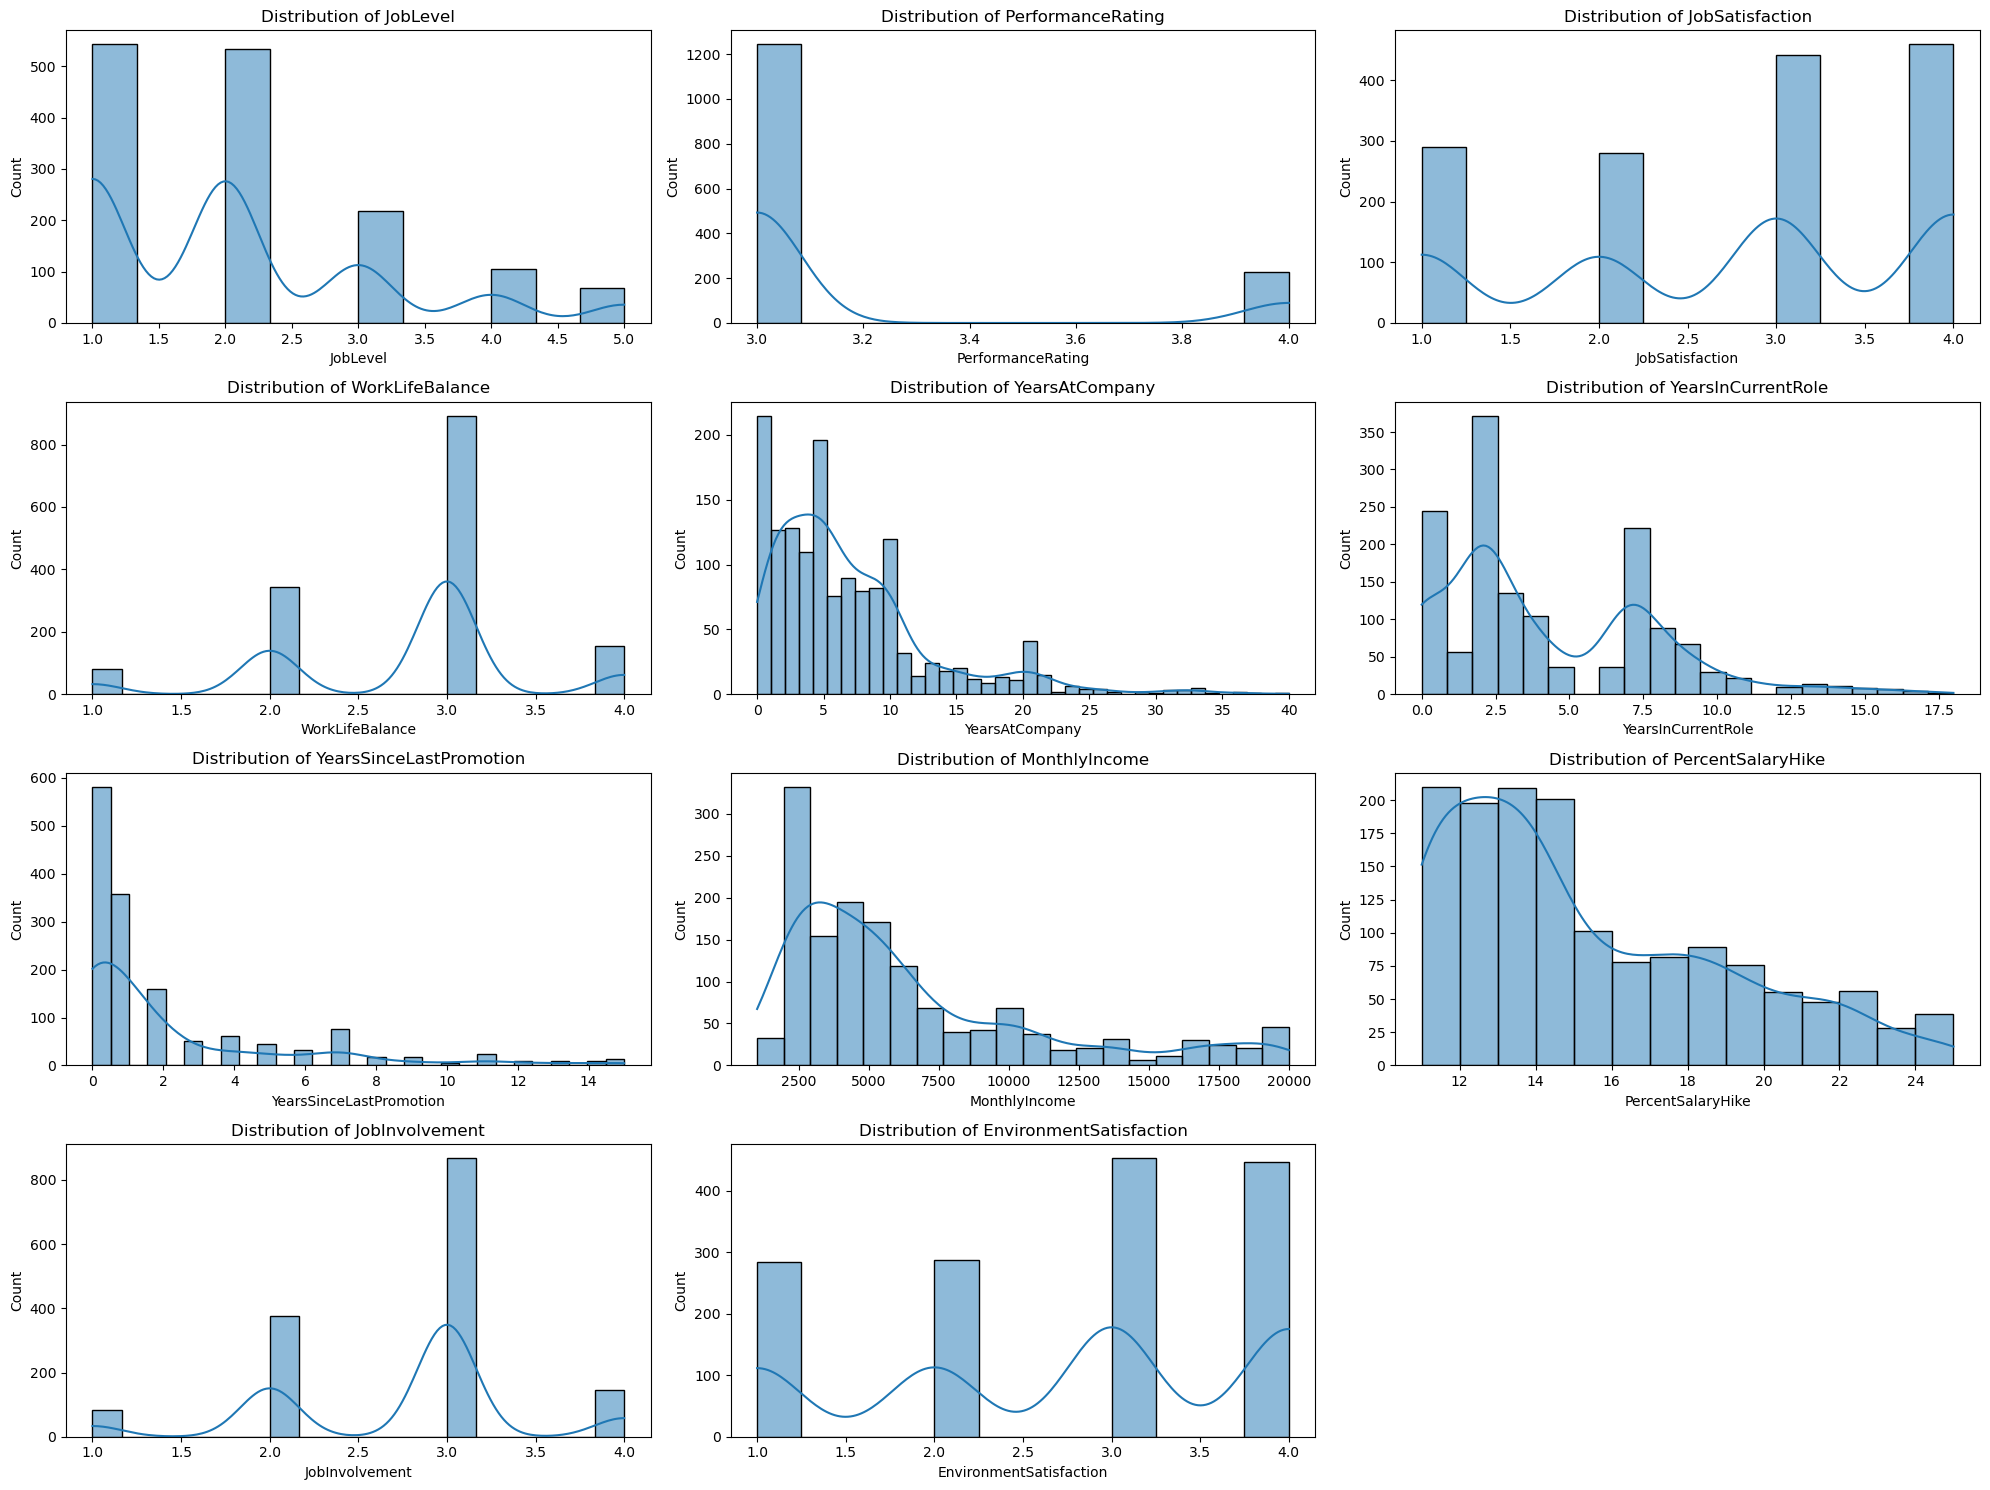

In [31]:

plt.figure(figsize=(20, 15))

for i, var in enumerate(performance_vars):
    plt.subplot(4, 3, i+1)
    sns.histplot(df[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.tight_layout()
plt.show()

## Observations

1. **Ordinal Variables (JobLevel, PerformanceRating, JobSatisfaction, WorkLifeBalance, JobInvolvement, EnvironmentSatisfaction)**  
   - These variables typically range from **1 to 4 or 1 to 5** (depending on the scale).  
   - The boxes (representing the interquartile range) are relatively narrow because the data can only take on a few discrete values.  
   - Outliers in these variables are either absent or minimal, as the scale limits extreme values.

2. **Tenure-Related Variables (YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion)**  
   - These show more potential for **spread** in the data, because employees can vary widely in how long they have been with the company or in a particular role.  
   - The box plots may reveal outliers (dots beyond the whiskers), indicating employees who have exceptionally long tenures or who have not been promoted in a much longer timeframe than others.

3. **MonthlyIncome**  
   - This variable often exhibits **right-skewed** behavior (a small number of high earners).  
   - The box plot may have a large box (interquartile range) and a long tail, with outliers representing significantly higher salaries.  
   - This aligns with typical salary distributions, where most employees cluster around lower to mid-range salaries, and a few earn substantially more.

4. **PercentSalaryHike**  
   - Ranges are narrower (often between 11% and 25% in many HR datasets).  
   - While outliers can occur, the box plot typically reveals whether certain employees received unusually high percentage increases compared to the majority.


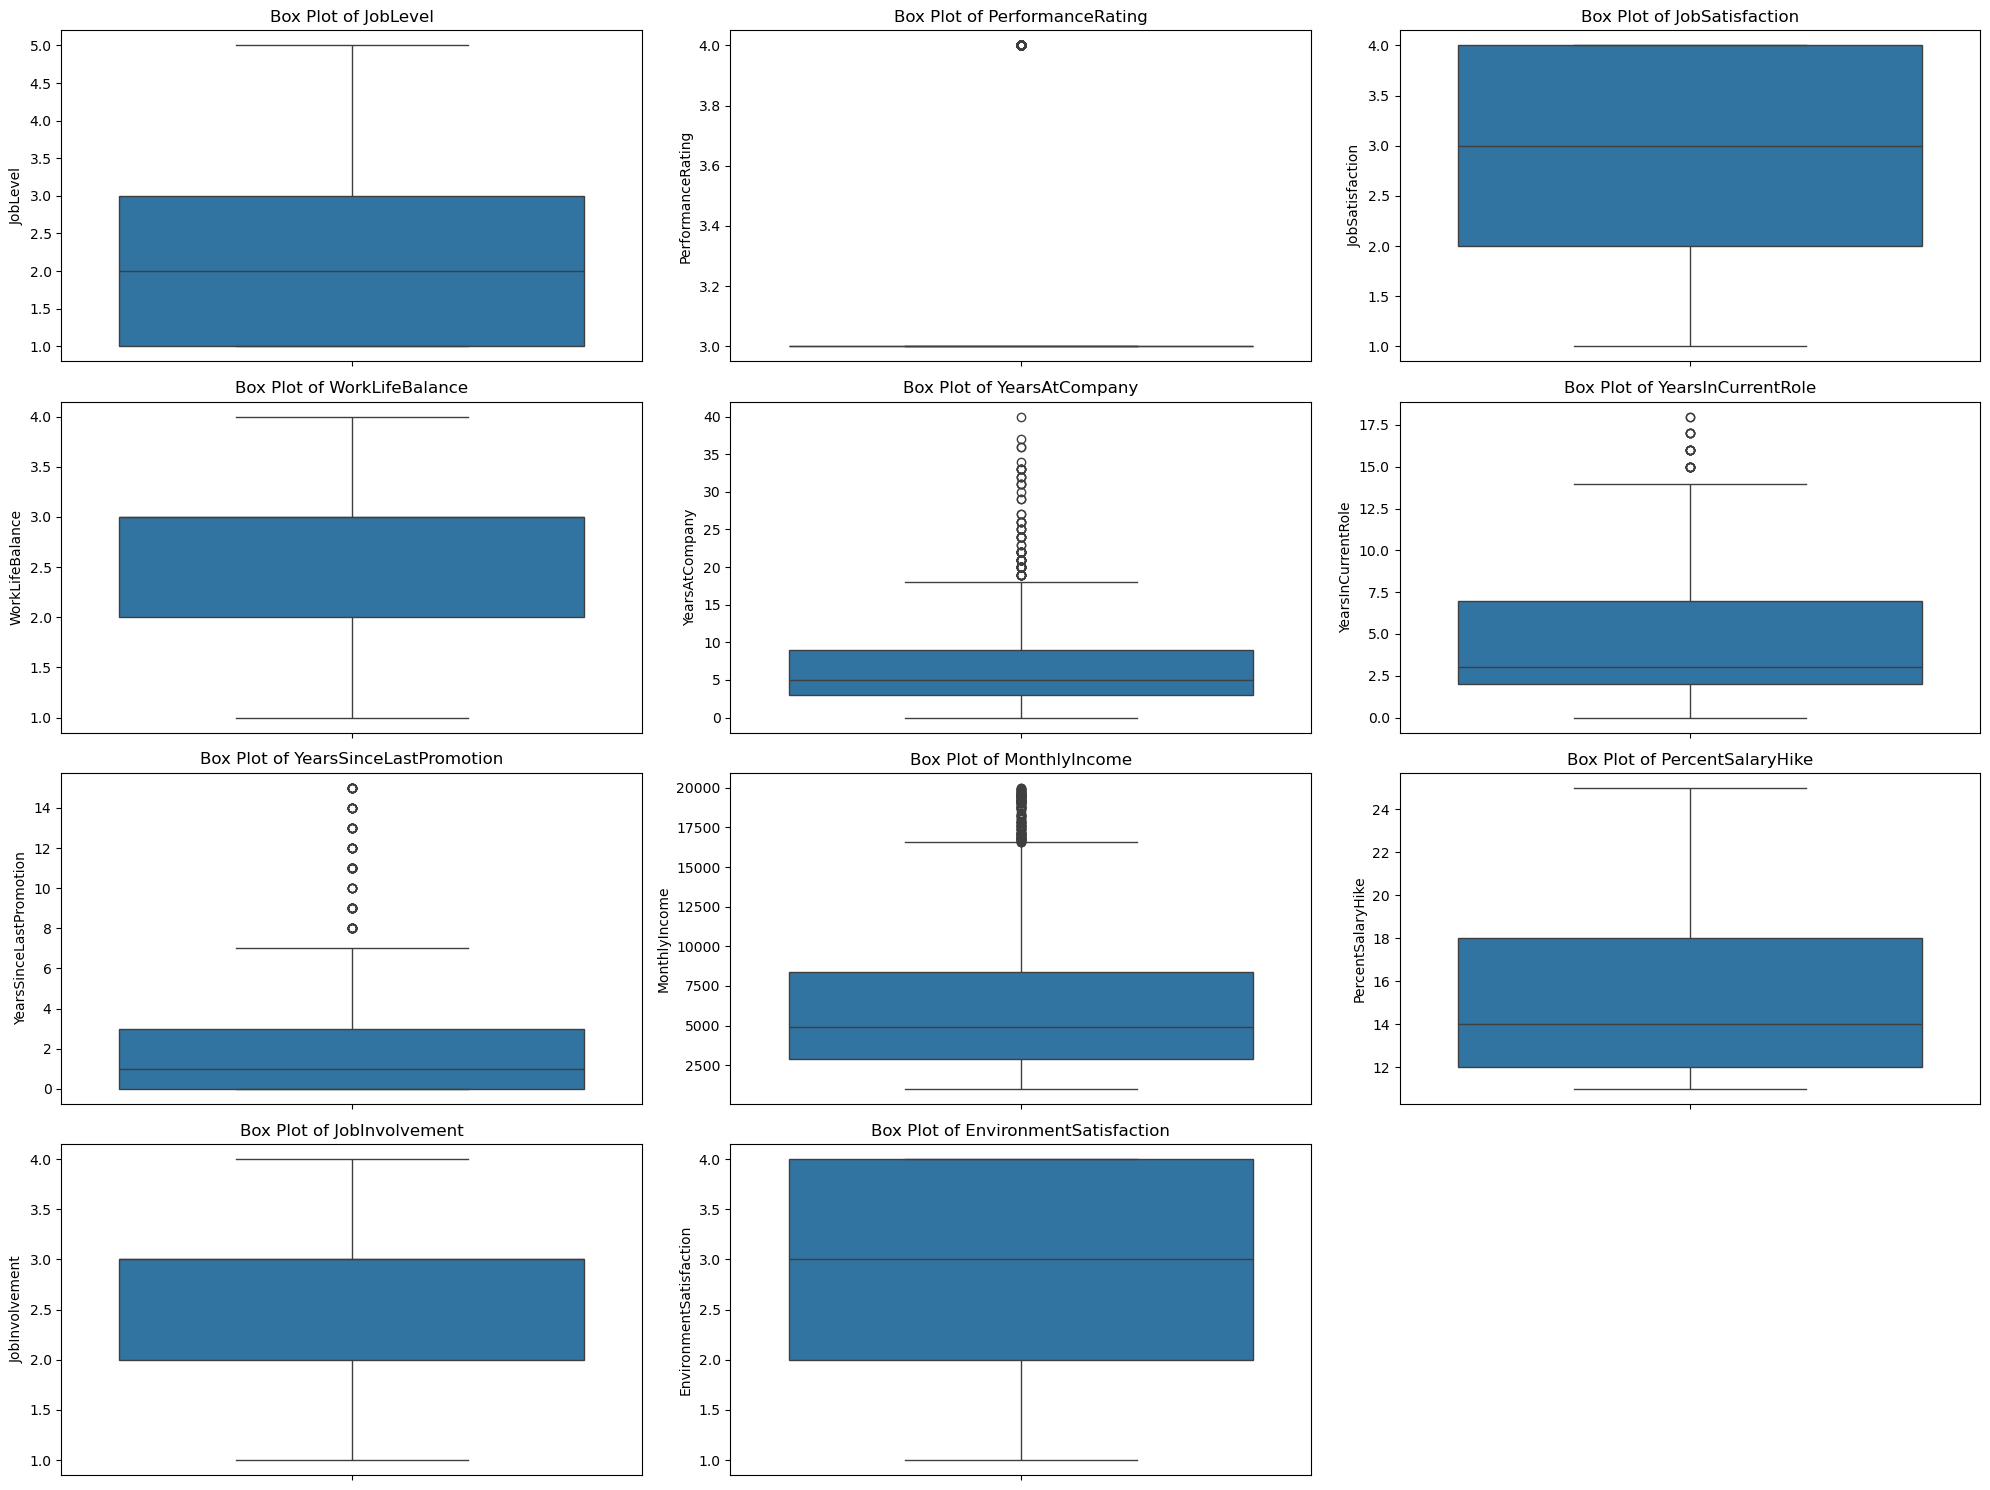

In [32]:
# 2. Box Plots to Identify Outliers
# Why: Outliers can significantly impact PCA results and should be identified early
# PCA is sensitive to outliers as they can disproportionately influence the direction of principal components
plt.figure(figsize=(20, 15))
for i, var in enumerate(performance_vars):
    plt.subplot(4, 3, i+1)
    sns.boxplot(y=df[var])
    plt.title(f'Box Plot of {var}')
    plt.tight_layout()
plt.show()

- **High Positive Skewness (> 1):**  
  - **PerformanceRating (1.92):** Indicates a significant right-skew, meaning that while most employees have lower ratings, a few have exceptionally high ratings.
  - **YearsAtCompany (1.76):** A right-skewed distribution suggests that most employees have shorter tenures, with a smaller number having very long tenures.
  - **YearsSinceLastPromotion (1.98):** Similarly, this shows that the majority of employees have been promoted recently, while a few have had long gaps since their last promotion.
  - **MonthlyIncome (1.37):** Many employees earn at the lower end, but a small number earn much higher salaries, pulling the distribution to the right.
  - **JobLevel (1.03):** Borderline skewness; might be acceptable but should be monitored.

- **Moderate to Low Skewness (< 1):**  
  - Variables such as **JobSatisfaction, WorkLifeBalance, JobInvolvement, and EnvironmentSatisfaction** have skewness values closer to zero (and some are slightly negative), indicating relatively symmetric distributions that are less likely to impact PCA.


In [33]:
# 3. Skewness Analysis
# Why: High skewness can affect PCA results; variables with skewness > 1 might need transformation
# PCA works best with normally distributed data, and transformations can help achieve this
skewness = pd.DataFrame(df[performance_vars].skew(), columns=['Skewness'])
print("\nSkewness Analysis:")
display(skewness)


Skewness Analysis:


,Skewness
JobLevel,1.025401
PerformanceRating,1.921883
JobSatisfaction,-0.329672
WorkLifeBalance,-0.552480
YearsAtCompany,1.764529
YearsInCurrentRole,0.917363
YearsSinceLastPromotion,1.984290
MonthlyIncome,1.369817
PercentSalaryHike,0.821128
JobInvolvement,-0.498419


In [34]:
# 4. Multivariate Outlier Detection using Mahalanobis Distance
# Why: This identifies observations that are outliers in the multivariate space
# Univariate outliers might not be multivariate outliers and vice versa

# Select numeric columns for outlier detection
numeric_df = df.select_dtypes(include=[np.number])
# Remove constant columns
numeric_df = numeric_df.loc[:, numeric_df.std() > 0]

# Calculate Mahalanobis distance
x_centered = numeric_df - numeric_df.mean()
cov = numeric_df.cov()
try:
    inv_cov = np.linalg.inv(cov)
    # Calculate Mahalanobis distance for each observation
    mahalanobis_dist = np.array([np.sqrt(np.dot(np.dot(x_i, inv_cov), x_i.T)) 
                                for x_i in x_centered.values])
    
    # Determine threshold based on chi-square distribution
    threshold = chi2.ppf(0.975, df=len(numeric_df.columns))
    
    # Identify outliers
    outliers = np.where(mahalanobis_dist > threshold)[0]
    print(f"\nNumber of multivariate outliers detected: {len(outliers)}")
    print(f"Percentage of outliers: {len(outliers)/len(df)*100:.2f}%")
    
    # Add Mahalanobis distance to dataframe for reference
    df['Mahalanobis'] = mahalanobis_dist
except np.linalg.LinAlgError:
    print("\nCould not calculate Mahalanobis distance due to singular covariance matrix.")
    print("This suggests perfect multicollinearity among some variables.")


Could not calculate Mahalanobis distance due to singular covariance matrix.
This suggests perfect multicollinearity among some variables.


# Feature Engineering - Create Composite Variables

**Why:** These derived features might capture performance aspects better than raw variables. Complex relationships between variables can sometimes be better represented by composite metrics.

- **ProductivityRatio:**  
  The values indicate how much monthly income is generated per year of work experience. For instance, a ProductivityRatio of 665.89 suggests a high income relative to the employee’s total working experience, potentially flagging high performers or those generating more value relative to their experience.

- **CareerProgressionSpeed:**  
  This ratio provides insight into how quickly an employee advances to a higher job level relative to their tenure. A higher ratio means that an employee has achieved a higher job level in a shorter period, which may indicate rapid career advancement or exceptional performance.

- **SatisfactionComposite:**  
  Averaging several satisfaction measures gives a holistic view of an employee’s satisfaction. Values around 2.00 to 3.25 suggest varying levels of overall satisfaction among employees. This composite score can help in understanding overall sentiment, which might be related to performance and retention.

In [35]:
# 5. Feature Engineering - Create Composite Variables
# Why: These derived features might capture performance aspects better than raw variables
# Complex relationships between variables can sometimes be better represented by composite metrics

# Productivity ratio: Income relative to experience
df['ProductivityRatio'] = df['MonthlyIncome'] / (df['TotalWorkingYears'] + 1)  # Adding 1 to avoid division by zero

# Career progression speed: Ratio of current role to total years
df['CareerProgressionSpeed'] = df['JobLevel'] / (df['YearsAtCompany'] + 1)  # Adding 1 to avoid division by zero

# Satisfaction composite score
satisfaction_cols = ['JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'RelationshipSatisfaction']
if all(col in df.columns for col in satisfaction_cols):
    df['SatisfactionComposite'] = df[satisfaction_cols].mean(axis=1)
    
# Display the first few rows with new features
print("\nDataFrame with new engineered features:")
display(df[['ProductivityRatio', 'CareerProgressionSpeed', 'SatisfactionComposite']].head())


DataFrame with new engineered features:


,ProductivityRatio,CareerProgressionSpeed,SatisfactionComposite
0,665.888889,0.285714,2.00
1,466.363636,0.181818,3.00
2,261.250000,1.000000,3.00
3,323.222222,0.111111,3.25
4,495.428571,0.333333,2.50


In [36]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,ProductivityRatio,CareerProgressionSpeed,SatisfactionComposite
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,8,0,1,6,4,0,5,665.888889,0.285714,2.00
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,10,3,3,10,7,1,7,466.363636,0.181818,3.00
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,7,3,3,0,0,0,0,261.250000,1.000000,3.00
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,8,3,3,8,7,3,0,323.222222,0.111111,3.25
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,6,3,3,2,2,2,2,495.428571,0.333333,2.50


# Data Transformation for Skewed Variables
**Why:** Transform highly skewed variables to improve normality. Log transformations can help normalize right-skewed data, making PCA more effective.

- **Improving Normality:**  
  PCA performs best when the input data approximates a normal distribution. By applying log transformations to highly right-skewed variables, the distributions become more symmetric. For example, the significant reduction in skewness for *JobLevel* (from 1.025 to 0.220) and *MonthlyIncome* (from 1.370 to 0.286) shows that these variables are now closer to normal.

- **Enhanced Robustness of PCA:**  
  Outliers and heavy skewness can distort the principal components by giving undue influence to extreme values. Normalizing these variables minimizes this risk, allowing PCA to capture the underlying structure of the data more accurately.

- **Variable-Specific Effects:**  
  Not every variable responds to log transformation in the same way. For instance, *PerformanceRating* remains highly skewed (1.922) even after the transformation, suggesting that:  
  - The variable might have a discrete scale or limited range.  
  - An alternative transformation (or even leaving it untransformed) might be more appropriate.


Highly skewed variables that might benefit from transformation: ['JobLevel', 'PerformanceRating', 'YearsAtCompany', 'YearsSinceLastPromotion', 'MonthlyIncome']
Created log transformation of JobLevel
  Original skewness: 1.025, Log-transformed skewness: 0.220


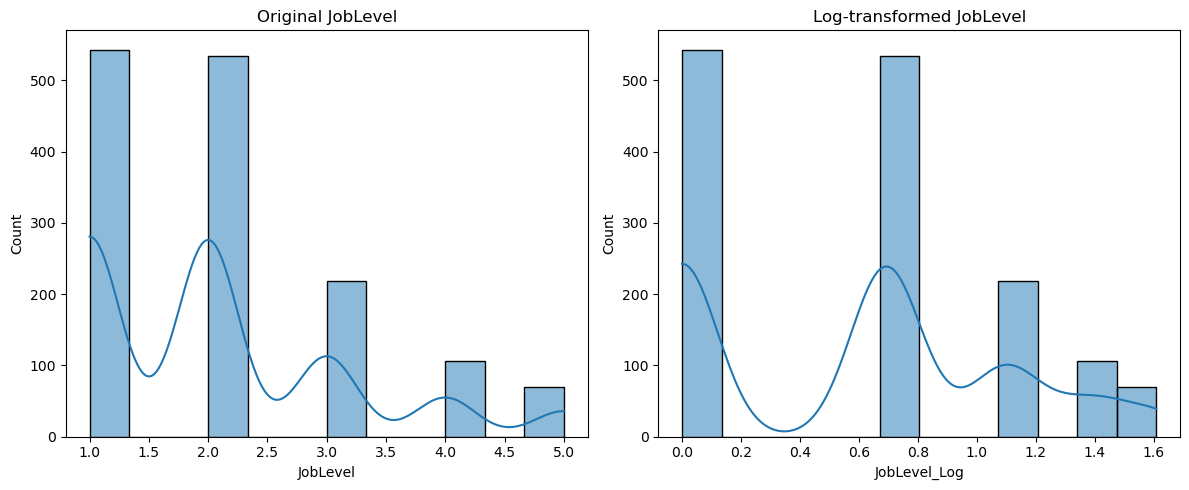

Created log transformation of PerformanceRating
  Original skewness: 1.922, Log-transformed skewness: 1.922


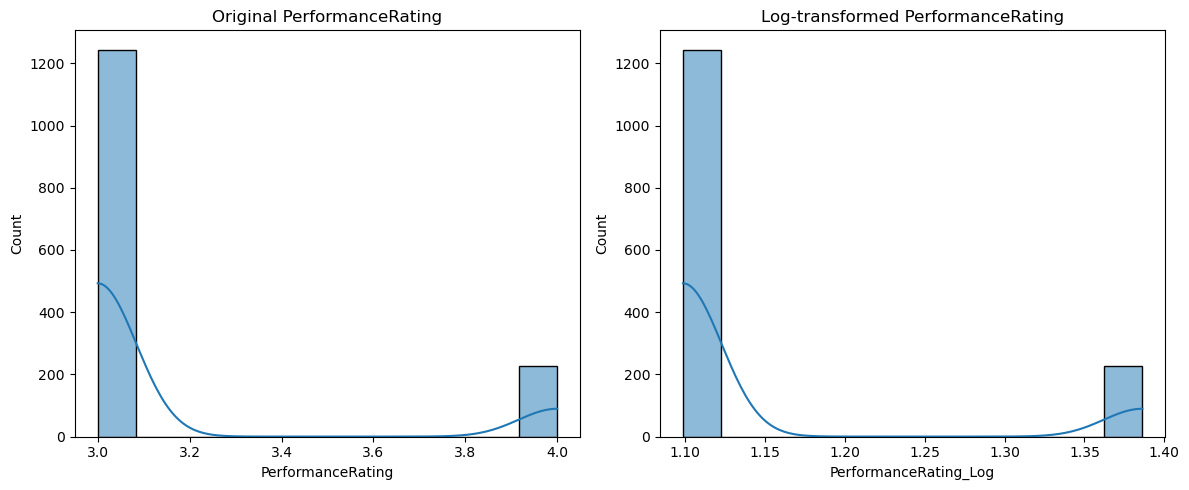

Created log transformation of MonthlyIncome
  Original skewness: 1.370, Log-transformed skewness: 0.286


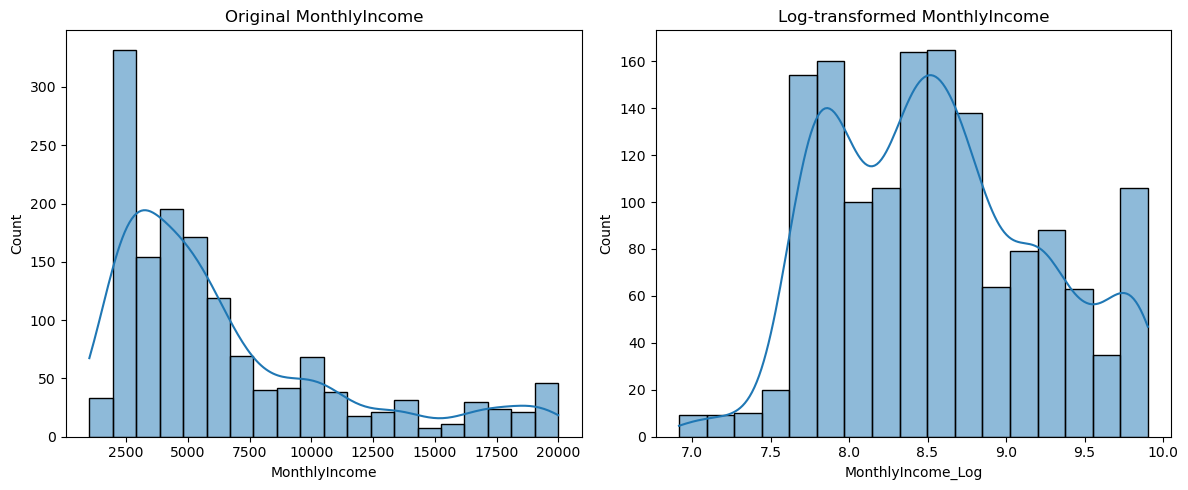

In [37]:
# 6. Data Transformation for Skewed Variables
# Why: Transform highly skewed variables to improve normality
# Log transformations can help normalize right-skewed data, making PCA more effective
skewed_vars = skewness[skewness['Skewness'].abs() > 1].index.tolist()
print(f"\nHighly skewed variables that might benefit from transformation: {skewed_vars}")

# Create transformed versions of skewed variables
for var in skewed_vars:
    if df[var].min() > 0:  # Only transform positive variables
        df[f'{var}_Log'] = np.log(df[var])
        print(f"Created log transformation of {var}")
        
        # Compare skewness before and after transformation
        original_skew = df[var].skew()
        transformed_skew = df[f'{var}_Log'].skew()
        print(f"  Original skewness: {original_skew:.3f}, Log-transformed skewness: {transformed_skew:.3f}")
        
        # Visualize the transformation
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df[var], kde=True)
        plt.title(f'Original {var}')
        
        plt.subplot(1, 2, 2)
        sns.histplot(df[f'{var}_Log'], kde=True)
        plt.title(f'Log-transformed {var}')
        plt.tight_layout()
        plt.show()

# Correlation Analysis with New Features
**Why:** Check if new derived features have stronger correlations with performance indicators. This can help identify more meaningful variables for PCA.

- **Derived Features vs. Original Variables**  
  - **ProductivityRatio** may show a noticeable correlation (positive or negative) with income-related or experience-related variables. A strong correlation suggests that the new feature might be capturing an aspect of performance not fully reflected in the raw variables alone.  
  - **CareerProgressionSpeed** likely correlates with `JobLevel` and `YearsAtCompany`, indicating how quickly an individual advances relative to their tenure.  
  - **SatisfactionComposite** should have moderate-to-strong positive correlations with satisfaction-related variables (e.g., `JobSatisfaction`, `EnvironmentSatisfaction`), suggesting it effectively consolidates multiple satisfaction metrics into one.

- **Log-Transformed Variables**  
  - Log transformations (e.g., `MonthlyIncome_Log`) can reduce skewness, sometimes altering the strength or direction of correlations. If `MonthlyIncome_Log` is more closely correlated with other performance indicators than `MonthlyIncome`, it indicates that the transformation may improve how this variable relates to the rest of the dataset.

- **Identifying Red/Blue Patches**  
  - **Red patches** signify positive relationships. For instance, if `JobLevel_Log` and `MonthlyIncome_Log` show a bright red square, it implies higher job levels tend to correlate with higher incomes in a more linear/log-linear fashion.  
  - **Blue patches** indicate inverse relationships. A strong blue cell might show, for example, that a higher `CareerProgressionSpeed` is negatively related to certain time-based variables, reflecting faster advancement in fewer years.

---

## Value for PCA
Correlation analysis helps confirm whether newly engineered features (or log transformations) are more strongly tied to known performance indicators. Variables that exhibit strong correlations with multiple performance-related metrics could be more informative for PCA.

## Reducing Dimensionality More Effectively
If the new features capture multiple underlying factors, they may help PCA produce components that explain a larger share of variance. This can lead to more **insightful** principal components that are easier to interpret.

## Potential Next Steps
- **Feature Selection:** Decide which variables to include in the final PCA based on the strength and relevance of their correlations.  
- **Further Transformation:** If certain variables remain highly skewed or poorly correlated, additional transformations or alternate composite metrics could be considered.  
- **Interpretation & Policy:** Ultimately, the correlations guide HR decisions. For example, a strong positive correlation between `CareerProgressionSpeed` and `PerformanceRating` might inform how promotions are tied to performance.

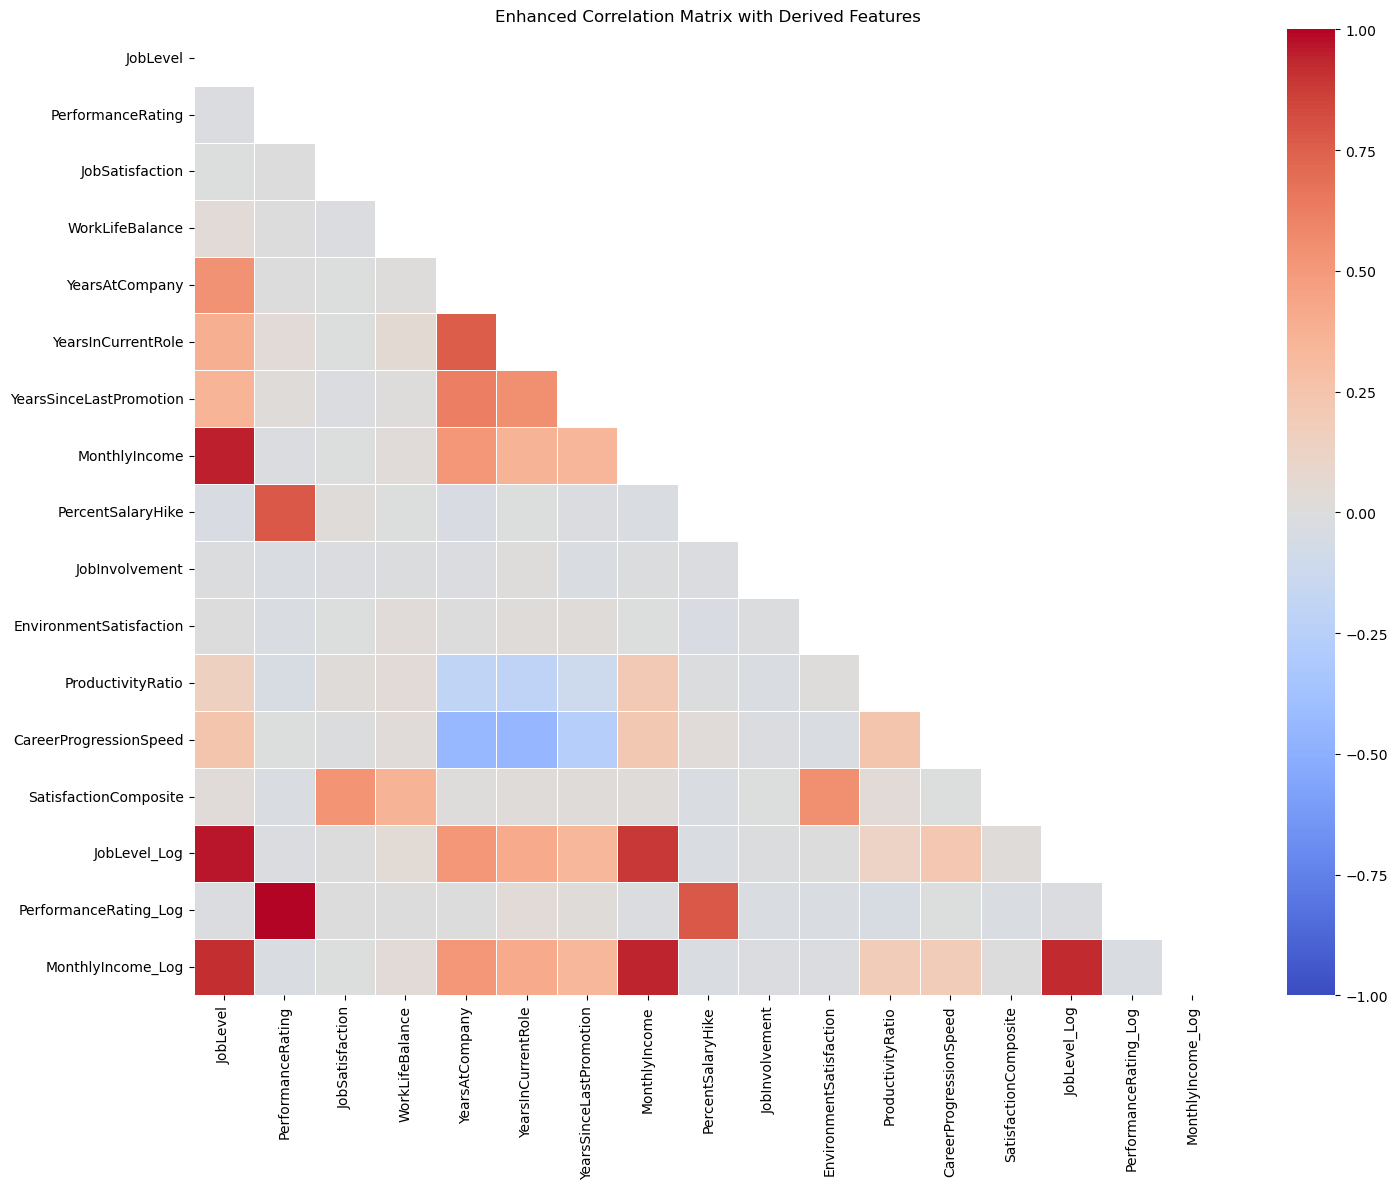


Enhanced exploratory analysis complete. These insights will inform our PCA approach.


In [38]:
# 7. Correlation Analysis with New Features
# Why: Check if new derived features have stronger correlations with performance indicators
# This can help identify more meaningful variables for PCA
new_features = ['ProductivityRatio', 'CareerProgressionSpeed']
if 'SatisfactionComposite' in df.columns:
    new_features.append('SatisfactionComposite')
    
# Add log-transformed variables
log_vars = [col for col in df.columns if col.endswith('_Log')]
analysis_vars = performance_vars + new_features + log_vars

# Create correlation matrix with all relevant variables
correlation_enhanced = df[analysis_vars].corr()

# Visualize enhanced correlation matrix
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(correlation_enhanced))
sns.heatmap(correlation_enhanced, annot=False, mask=mask, cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, linewidths=0.5)
plt.title('Enhanced Correlation Matrix with Derived Features')
plt.tight_layout()
plt.show()

print("\nEnhanced exploratory analysis complete. These insights will inform our PCA approach.")

- **perform_cross_validation:**
  - Splits data into multiple folds.
  - Fits PCA on each training fold.
  - Measures how much variance is explained in each fold.
  - Returns the average and standard deviation of explained variance, giving a sense of how stable PCA’s total explained variance is across different subsets of data.

- **sensitivity_analysis:**
  - Scales data, then fits PCA with a specified number of components.
  - Examines the PCA loadings to determine which features have the highest overall impact.
  - Returns a feature ranking based on mean absolute loadings.

In [39]:
def perform_cross_validation(X, y, n_splits=5):
    """
    Performs k-fold cross-validation on the PCA model.
    """
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Scale the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Fit PCA
        pca = PCA()
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_val_pca = pca.transform(X_val_scaled)
        
        # Calculate explained variance ratio
        scores.append(np.sum(pca.explained_variance_ratio_))
    
    return np.mean(scores), np.std(scores)

def sensitivity_analysis(X, feature_names, n_components):
    """
    Performs sensitivity analysis on the PCA model.
    """
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Calculate feature importance
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=feature_names
    )
    
    # Calculate feature importance scores
    importance_scores = np.abs(loadings).mean(axis=1)
    
    return pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values('Importance', ascending=False)

STEP 2: Preliminary Statistical Analysis

## Observations 

1. **JobLevel vs. MonthlyIncome (0.95)**  
   - One of the strongest correlations in the matrix. This suggests that higher-level positions tend to have significantly higher monthly incomes, which is logical from an HR standpoint.

2. **PerformanceRating vs. PercentSalaryHike (0.77)**  
   - Indicates that employees with higher performance ratings often receive larger salary hikes. This relationship might be part of the company’s compensation or bonus policy.

3. **YearsAtCompany vs. YearsInCurrentRole (0.85)**  
   - Reflects that employees who have been with the company longer also tend to have spent more time in their current role.

4. **Moderate to Low Correlations**  
   - WorkLifeBalance and JobSatisfaction show weaker correlations with other variables, suggesting these metrics may vary somewhat independently from purely financial or tenure-related factors.

5. **Negative or Near-Zero Correlations**  
   - Some cells in the matrix (e.g., WorkLifeBalance vs. PerformanceRating at -0.02) are close to 0, indicating minimal linear relationship.

---

## Discussion

- **Relationship Insights:**  
  The correlation matrix reveals which factors move together, providing hints about compensation structures (e.g., high correlation of JobLevel and MonthlyIncome) and performance-related policies (e.g., strong link between PerformanceRating and PercentSalaryHike).

- **Policy Implications:**  
  - High correlation between **PerformanceRating** and **PercentSalaryHike** indicates a performance-driven raise system.  
  - **JobLevel** strongly tied to **MonthlyIncome** suggests a formalized pay grade structure based on position hierarchy.

- **Potential for Dimensionality Reduction:**  
  Strongly correlated variables (e.g., JobLevel and MonthlyIncome) might be partially redundant for certain modeling approaches, including PCA. Preliminary correlation checks help in deciding which variables to keep or combine.

- **Further Analysis:**  
  - **Data Transformations:** If some variables (like MonthlyIncome) are highly skewed, transformations could be considered.  
  - **Feature Engineering:** Composite variables or additional metrics may capture nuances not seen in raw data.  
  - **PCA Suitability:** This correlation overview informs how these performance indicators might cluster or align in principal components.

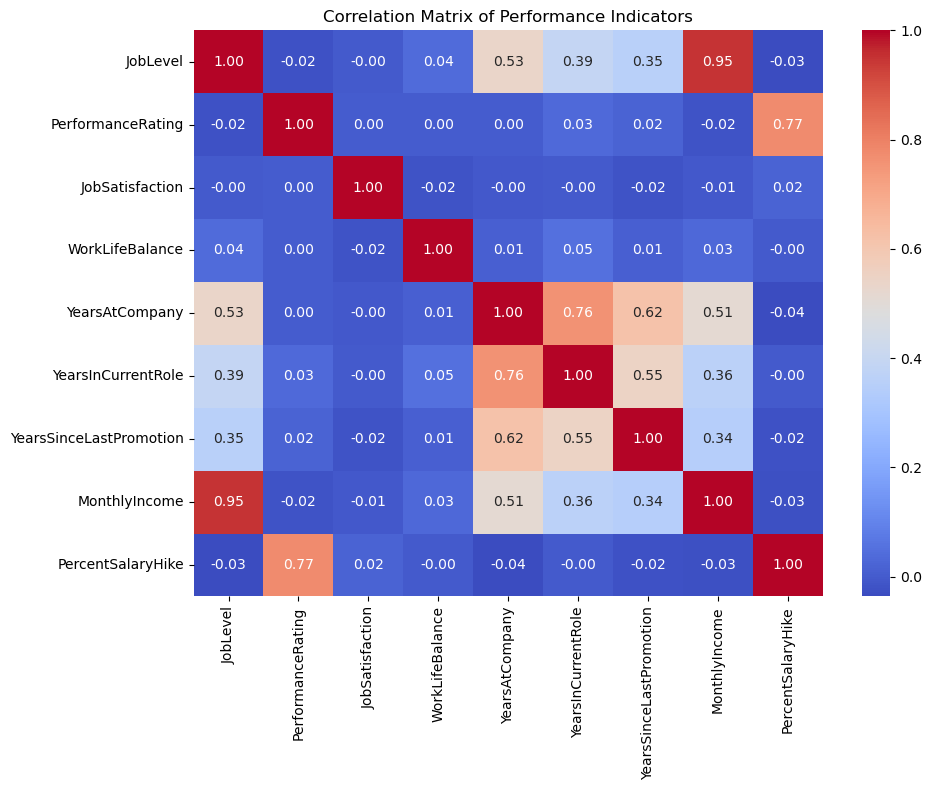


Descriptive Statistics of Performance Indicators:
          JobLevel  PerformanceRating  JobSatisfaction  WorkLifeBalance  \
count  1470.000000        1470.000000      1470.000000      1470.000000   
mean      2.063946           3.153741         2.728571         2.761224   
std       1.106940           0.360824         1.102846         0.706476   
min       1.000000           3.000000         1.000000         1.000000   
25%       1.000000           3.000000         2.000000         2.000000   
50%       2.000000           3.000000         3.000000         3.000000   
75%       3.000000           3.000000         4.000000         3.000000   
max       5.000000           4.000000         4.000000         4.000000   

       YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
count     1470.000000         1470.000000              1470.000000   
mean         7.008163            4.229252                 2.187755   
std          6.126525            3.623137                 3.222

In [40]:
# Create a subset of performance-related indicators
performance_columns = ['JobLevel', 'PerformanceRating', 'JobSatisfaction', 
                      'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
                      'YearsSinceLastPromotion', 'MonthlyIncome', 'PercentSalaryHike']
data_perf = df[performance_columns]

# Compute correlation matrix
cor_matrix = data_perf.corr()

# Visualize using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Performance Indicators")
plt.tight_layout()
plt.show()

# Display basic statistics of performance indicators
print("\nDescriptive Statistics of Performance Indicators:")
print(data_perf.describe())

STEP 3: PCA Prerequisites and Assumptions Testing

In [41]:
# Import additional packages
from factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import calculate_kmo
from scipy.stats import stats

# Standardize the data
scaler = StandardScaler()
data_perf_scaled = scaler.fit_transform(data_perf)
data_perf_scaled = pd.DataFrame(data_perf_scaled, columns=data_perf.columns)

# Test 1: Batlett's Test for Sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(data_perf)
print("\nBartlett's Test of Sphericity:")
print(f"Chi-Square value: {chi_square_value:.2f}")
print(f"p-value: {p_value:.5f}")

# Test 2: Kaiser-Meyer-Olkin (KMO) Test
kmo_all, kmo_model = calculate_kmo(data_perf)
print("\nKMO Test Results:")
print(f"KMO Score: {kmo_model:.3f}")  # Only print the model score

# Test 3: Determinant Check
determinant = np.linalg.det(data_perf.corr())
print("\nDeterminant of Correlation Matrix:", determinant)

# Additional Check: Verify data is suitable for PCA
print("\nData Suitability for PCA Summary:")
print("1. Bartlett's Test of Sphericity:", "Suitable" if p_value < 0.05 else "Not Suitable")
print("2. KMO Test:", "Suitable" if kmo_model > 0.6 else "Not Suitable")
print("3. Determinant of Correlation Matrix:", "Suitable" if determinant > 0.00001 else "Not Suitable")


Bartlett's Test of Sphericity:
Chi-Square value: 7280.37
p-value: 0.00000

KMO Test Results:
KMO Score: 0.658

Determinant of Correlation Matrix: 0.0069502802045814825

Data Suitability for PCA Summary:
1. Bartlett's Test of Sphericity: Suitable
2. KMO Test: Suitable
3. Determinant of Correlation Matrix: Suitable


In [42]:
class EmployeePerformanceScorer:
    """
    A class for implementing the PCA-based employee performance scoring system.
    """
    def __init__(self, pca_model, scaler, feature_names):
        self.pca_model = pca_model
        self.scaler = scaler
        self.feature_names = feature_names
    
    def score_employee(self, employee_data):
        """
        Calculate performance score for a single employee.
        """
        # Convert input to array
        X = np.array([employee_data[feature] for feature in self.feature_names])
        
        # Scale the data
        X_scaled = self.scaler.transform(X.reshape(1, -1))
        
        # Transform using PCA
        X_pca = self.pca_model.transform(X_scaled)
        
        # Calculate performance score (0-100)
        score = self._calculate_performance_score(X_pca)
        
        return score
    
    def _calculate_performance_score(self, X_pca):
        """
        Calculate the final performance score.
        """
        score = np.mean(X_pca) * 50 + 50  # Scale to 0-100
        return np.clip(score, 0, 100)
    
    def get_feature_importance(self):
        """
        Get the importance of each feature in the model.
        """
        loadings = pd.DataFrame(
            self.pca_model.components_.T,
            columns=[f'PC{i+1}' for i in range(self.pca_model.n_components_)],
            index=self.feature_names
        )
        return loadings

# Interpretation of Results
1. Bartlett's Test of Sphericity(0.000):
- If p-value < 0.05, the data is suitable for PCA.
- If p-value >= 0.05, the data is not suitable for PCA.
- There are significant relationships between the variables, which is excellent for PCA.

2. KMO Test(0.658):
- If KMO score > 0.6, the data is suitable for PCA.
- If KMO score <= 0.6, the data is not suitable for PCA.
- The score of 0.658 is above the minimum threshold (0.6) but is in the "mediocre" range. This suggests that while PCA is possible, the shared variance among variables is not particularly strong.

3. Determinant of Correlation Matrix(0.00001):
- If determinant > 0.00001, the data is suitable for PCA.
- If determinant <= 0.00001, the data is not suitable for PCA.
- The score of (0.00001) indicates that while there is multicollinearity (as expected and desired for PCA), it's not at a problematic level. The matrix is invertible and suitable for factor analysis.



STEP 4: Perform Principal Component Analysis


Variance Explained by Each Component:
 Component  Individual_Explained_Variance  Cumulative_Explained_Variance
         1                       0.351860                       0.351860
         2                       0.197321                       0.549181
         3                       0.121476                       0.670657
         4                       0.113181                       0.783838
         5                       0.108954                       0.892792
         6                       0.052851                       0.945643
         7                       0.025034                       0.970677
         8                       0.023859                       0.994536
         9                       0.005464                       1.000000


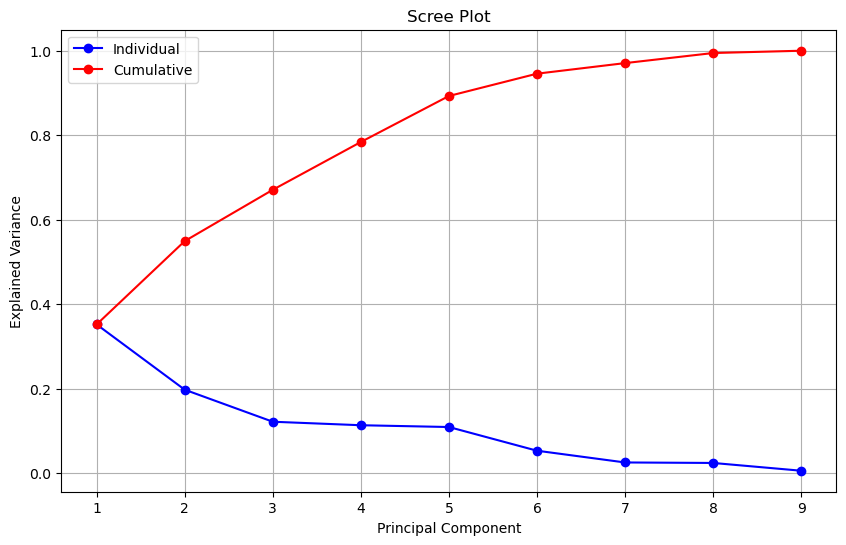

In [43]:
from sklearn.decomposition import PCA

# Initialize PCA (start with same number of components as original features)
n_components = len(performance_columns)
pca = PCA(n_components=n_components)

# Fit and Transform the data
pca_result = pca.fit_transform(data_perf_scaled)

# Calculate variance and cumulative variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create a DataFrame with explained variance 
variance_df = pd.DataFrame({
    'Component': range(1, n_components + 1),
    'Individual_Explained_Variance': explained_variance_ratio,
    'Cumulative_Explained_Variance': cumulative_variance
})

# Display variance explained by each component
print("\nVariance Explained by Each Component:")
print(variance_df.to_string(index=False))

# Create a scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), explained_variance_ratio, 'bo-', label='Individual')
plt.plot(range(1, n_components + 1), cumulative_variance, 'ro-', label='Cumulative')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.legend()
plt.grid(True)
plt.show()




Key Findings: 
1. First 4 components explain 78.38% of the variance.
- PC1: 35.19%
- PC2: 19.73%
- PC3: 12.15%
- PC4: 11.32%

2. Elbow point is around 4-5 components, where the individual variance drops off significantly.

3. We will keep 5 components
- 5 components = 89.28% of the variance




Step 5: Component Interpretation and Performance Modeling


Component Loadings:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
JobLevel,0.462249,-0.020283,0.518141,0.017952,-0.046340,0.020042,-0.002515,-0.084177,0.712377
PerformanceRating,-0.007177,0.706354,0.022482,-0.018526,-0.018530,0.013097,0.699489,-0.101780,-0.002247
JobSatisfaction,-0.007081,0.019508,0.048969,0.711686,0.699816,0.026015,0.014972,-0.003915,-0.004021
WorkLifeBalance,0.028846,0.001091,0.072350,-0.701096,0.706870,0.039117,0.001271,0.034311,-0.004703
YearsAtCompany,0.486196,0.017980,-0.281401,0.025134,0.009785,-0.252834,0.114787,0.778562,-0.010778
YearsInCurrentRole,0.430315,0.050598,-0.423886,-0.015951,0.067417,-0.529088,-0.106217,-0.579849,-0.018693
YearsSinceLastPromotion,0.395839,0.029110,-0.415133,0.007222,-0.004802,0.806981,-0.045808,-0.129165,0.007297
MonthlyIncome,0.454258,-0.016738,0.537377,0.019040,-0.057859,0.046274,-0.011772,-0.081894,-0.701355
PercentSalaryHike,-0.028223,0.704457,0.058459,0.001128,-0.009497,-0.001128,-0.695549,0.124854,0.007535


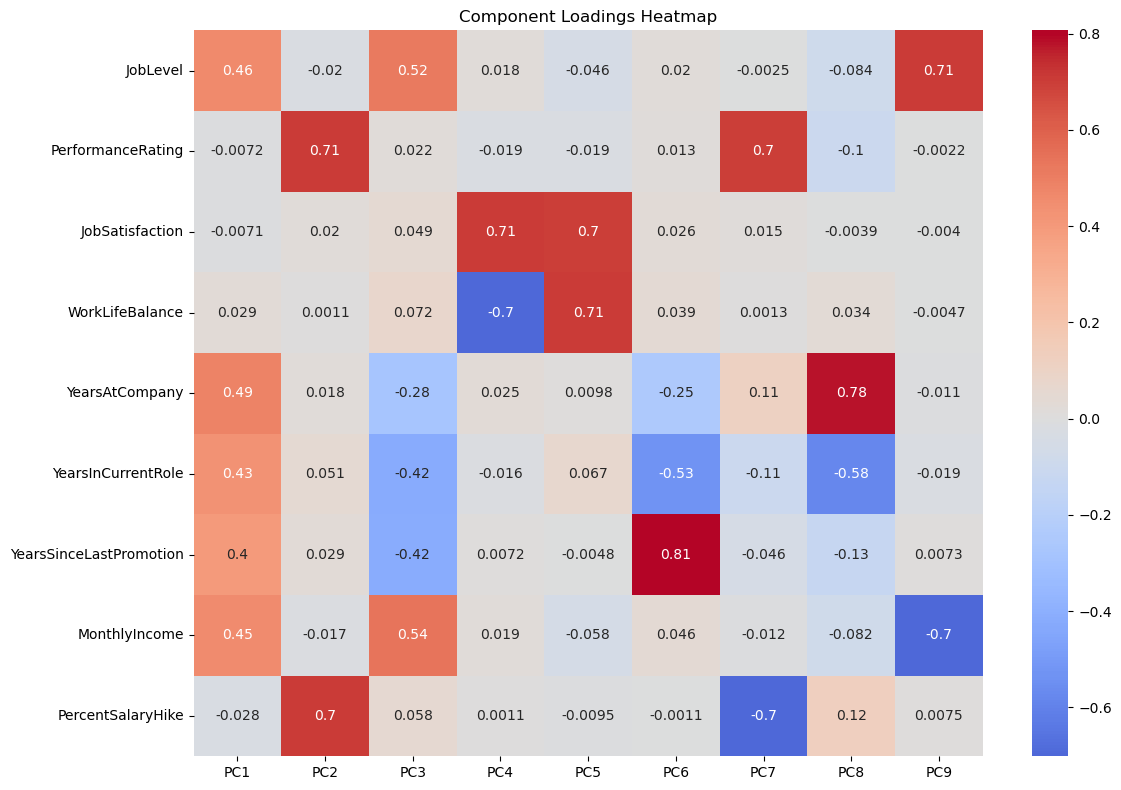

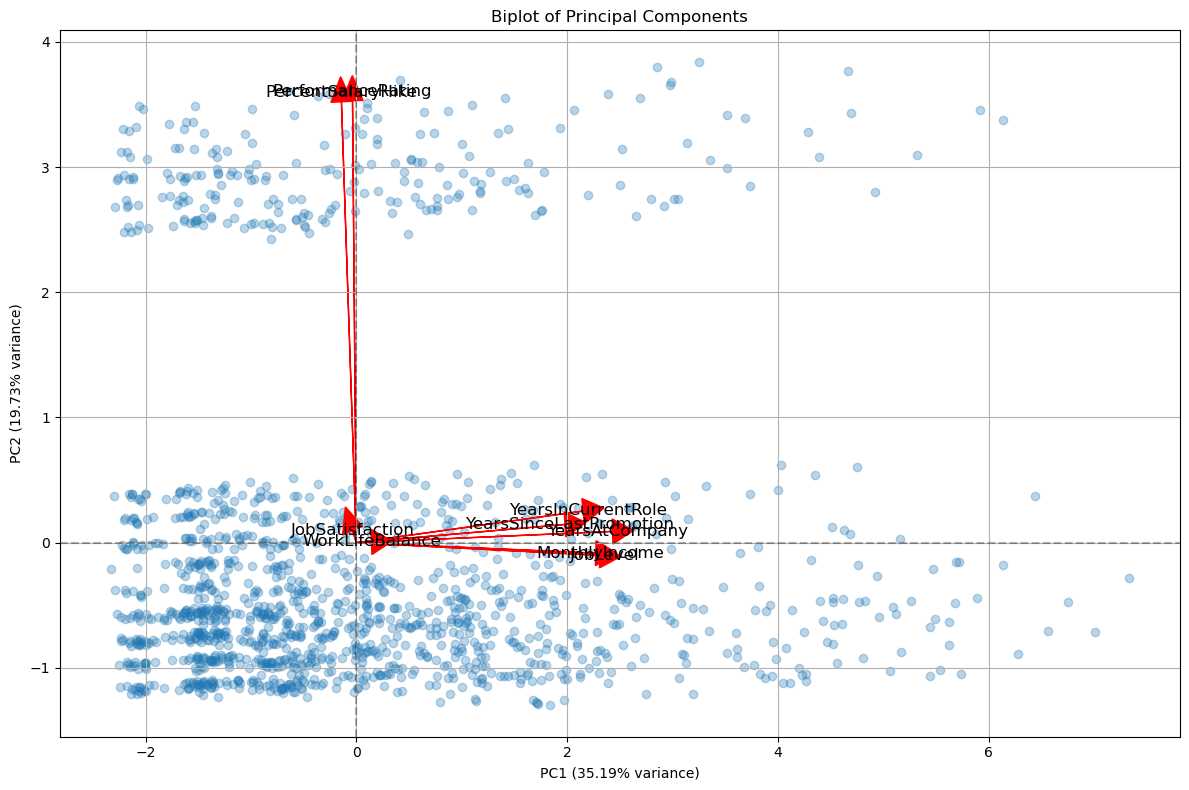

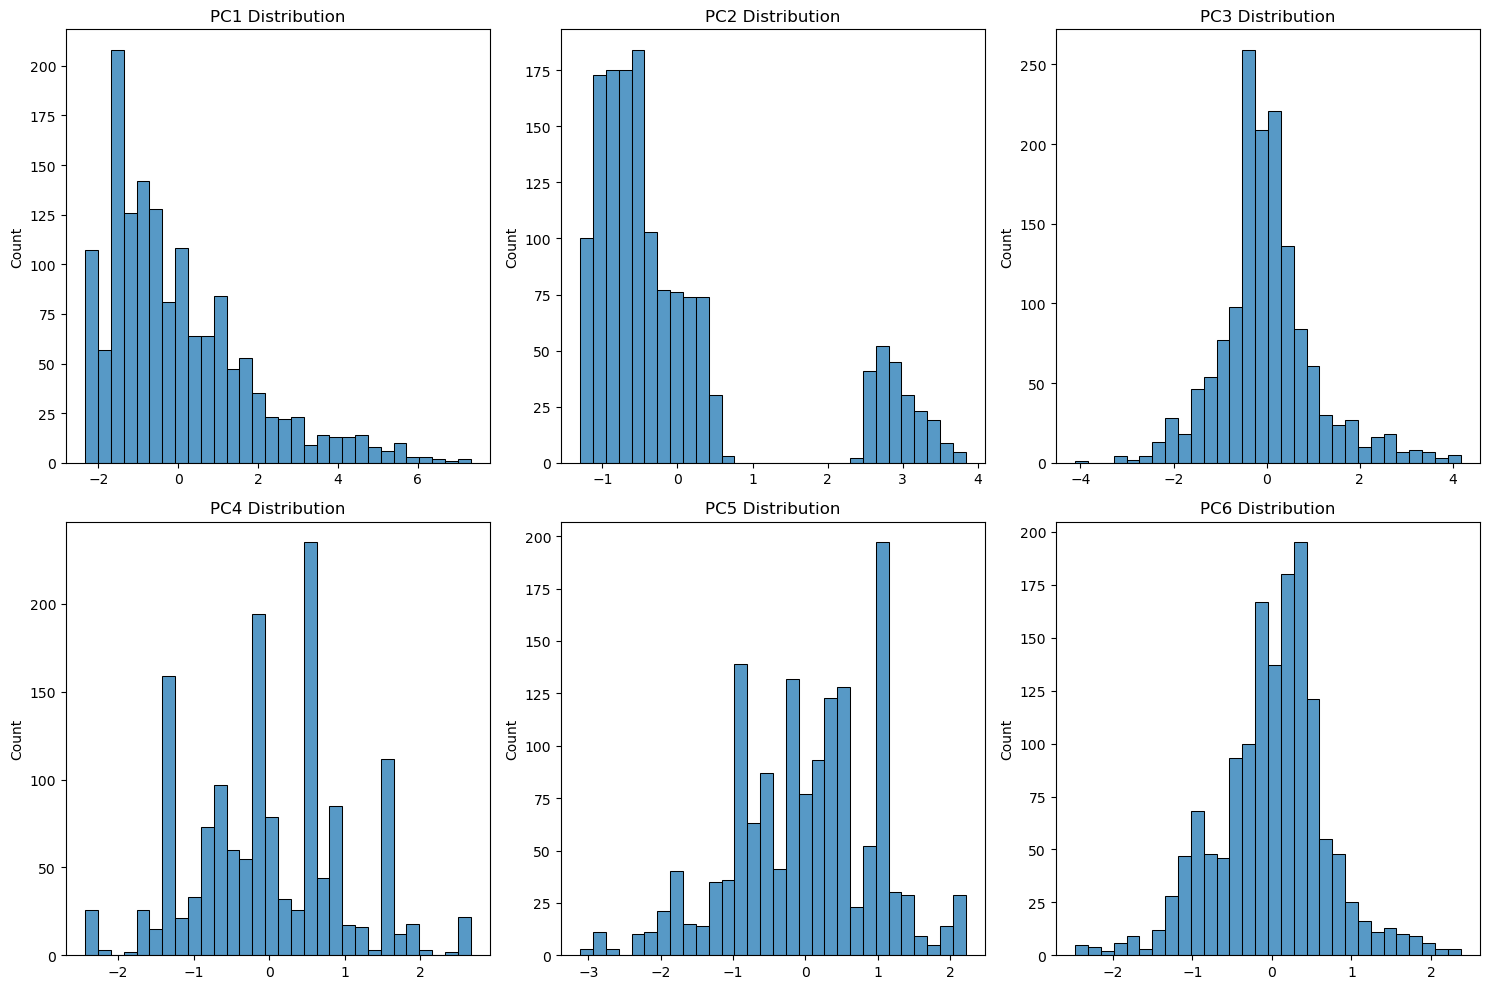

ImportError: cannot import name 'calculate_cronbach_alpha' from 'factor_analyzer' (/opt/anaconda3/lib/python3.12/site-packages/factor_analyzer/__init__.py)

In [44]:
# Step 5: Component Interpretation and Performance Modeling

# Examine component loadings
component_loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=performance_columns
)

# Display component loadings
print("\nComponent Loadings:")
display(component_loadings)

# Create a heatmap of component loadings
plt.figure(figsize=(12, 8))
sns.heatmap(component_loadings, annot=True, cmap='coolwarm', center=0)
plt.title('Component Loadings Heatmap')
plt.tight_layout()
plt.show()

# calculate component scores for each observation
pca_scores = pca.transform(data_perf_scaled)
pca_scores_df = pd.DataFrame(
    pca_scores[:, :n_components],
    columns=[f'PC{i+1}' for i in range(n_components)],
)

# Convert to 0-100 scale for easier interpretation
def scale_to_0_100(series):
    return 100 * (series - series.min()) / (series.max() - series.min())

pca_scores_scaled = pca_scores_df.apply(scale_to_0_100)

# Visualize component loadings with biplot
plt.figure(figsize=(12, 8))
# Plot scatter of observations in PC space (first 2 components)
plt.scatter(pca_scores[:, 0], pca_scores[:, 1], alpha=0.3)

# Plot feature vectors
for i, feature in enumerate(performance_columns):
    plt.arrow(0, 0,
              component_loadings.iloc[i, 0] * 5,
              component_loadings.iloc[i, 1] * 5,
              head_width=0.2, head_length=0.2, fc='red', ec='red')
    plt.text(component_loadings.iloc[i, 0] * 5.1,
             component_loadings.iloc[i, 1] * 5.1,
             feature,
             ha='center', va='center', fontsize=12)
plt.grid()
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.title('Biplot of Principal Components')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Create histograms of principal components
plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    sns.histplot(pca_scores[:, i], bins=30)
    plt.title(f'PC{i+1} Distribution')
plt.tight_layout()
plt.show()

# Assess reliability with Cronbach's alpha
from sklearn.preprocessing import scale
from factor_analyzer import calculate_cronbach_alpha

# Calculate Cronbach's alpha for the variables loading on each component
# For example, for PC1 (assuming we know which variables load highly on PC1)
# This is a simplified example - you'll need to identify which variables load on each component
pc1_variables = performance_columns[:3]  # Replace with actual variables that load on PC1
pc1_data = data_perf[pc1_variables]
alpha, _ = calculate_cronbach_alpha(scale(pc1_data))
print(f"Cronbach's alpha for PC1 variables: {alpha:.3f}")

# 5.7 Interpret components based on loadings
print("\nComponent Interpretation:")
for i in range(5):
    # Get the top contributing features for this component
    loadings = component_loadings[f'PC{i+1}'].abs().sort_values(ascending=False)
    top_features = loadings.head(3).index.tolist()
    print(f"\nPC{i+1} represents: {', '.join(top_features)}")
    print(f"Top loadings: {component_loadings.loc[top_features, f'PC{i+1}'].values}")

# 5.8 Add component scores to original dataset for further analysis
df_with_pca = df.copy()
for i in range(5):
    df_with_pca[f'PC{i+1}_Score'] = pca_scores_scaled[f'PC{i+1}']

# 5.9 Analyze relationship between components and target variable (if applicable)
# For example, if Attrition is a target variable:
if 'Attrition' in df.columns:
    plt.figure(figsize=(15, 10))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x='Attrition', y=f'PC{i+1}_Score', data=df_with_pca)
        plt.title(f'PC{i+1} by Attrition')
    plt.tight_layout()
    plt.show()
    
    # Statistical test for difference
    from scipy import stats
    for i in range(5):
        attrition_yes = df_with_pca[df_with_pca['Attrition'] == 'Yes'][f'PC{i+1}_Score']
        attrition_no = df_with_pca[df_with_pca['Attrition'] == 'No'][f'PC{i+1}_Score']
        t_stat, p_val = stats.ttest_ind(attrition_yes, attrition_no)
        print(f"PC{i+1} difference by Attrition: t={t_stat:.3f}, p={p_val:.4f}")
    

In [49]:
selected_features = [
    'Age', 'YearsAtCompany', 'MonthlyIncome', 'JobLevel', 'TotalWorkingYears',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
    'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
    'JobInvolvement', 'PerformanceRating', 'RelationshipSatisfaction'
]

# Prepare your data
X = df[selected_features].values

# Initialize and fit the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit the PCA model
# You can adjust n_components based on your previous analysis
pca_model = PCA(n_components=3)  # Adjust the number of components as needed
X_pca = pca_model.fit_transform(X_scaled)

# Now you can create the scorer
scorer = EmployeePerformanceScorer(pca_model, scaler, selected_features)

# Test with example employee data
employee_data = {
    'Age': 35,
    'YearsAtCompany': 5,
    'MonthlyIncome': 5000,
    'JobLevel': 2,
    'TotalWorkingYears': 10,
    'YearsInCurrentRole': 3,
    'YearsSinceLastPromotion': 2,
    'YearsWithCurrManager': 2,
    'EnvironmentSatisfaction': 3,
    'JobSatisfaction': 4,
    'WorkLifeBalance': 3,
    'JobInvolvement': 3,
    'PerformanceRating': 3,
    'RelationshipSatisfaction': 4
}

# Calculate performance score
score = scorer.score_employee(employee_data)
print(f"Employee Performance Score: {score:.2f}")

# Get feature importance
importance = scorer.get_feature_importance()
print("\nFeature Importance:")
print(importance)

# Initialize the scorer with your trained model
scorer = EmployeePerformanceScorer(pca_model, scaler, selected_features)

# Example employee data
employee_data = {
    'Age': 35,
    'YearsAtCompany': 5,
    'MonthlyIncome': 5000,
    'JobLevel': 2,
    'TotalWorkingYears': 10,
    'YearsInCurrentRole': 3,
    'YearsSinceLastPromotion': 2,
    'YearsWithCurrManager': 2,
    'EnvironmentSatisfaction': 3,
    'JobSatisfaction': 4,
    'WorkLifeBalance': 3,
    'JobInvolvement': 3,
    'PerformanceRating': 3,
    'RelationshipSatisfaction': 4
}

# Calculate performance score
score = scorer.score_employee(employee_data)
print(f"Employee Performance Score: {score:.2f}")

# Get feature importance
importance = scorer.get_feature_importance()
print("\nFeature Importance:")
print(importance)

Employee Performance Score: 45.25

Feature Importance:
                               PC1       PC2       PC3
Age                       0.271855 -0.401743  0.003675
YearsAtCompany            0.396898  0.287253  0.009701
MonthlyIncome             0.374863 -0.359615 -0.041172
JobLevel                  0.382935 -0.342985 -0.036502
TotalWorkingYears         0.402104 -0.265131 -0.033759
YearsInCurrentRole        0.340810  0.403064  0.016400
YearsSinceLastPromotion   0.301054  0.313778  0.033897
YearsWithCurrManager      0.335322  0.406787  0.032548
EnvironmentSatisfaction   0.002798  0.013284  0.315008
JobSatisfaction          -0.008369 -0.014469 -0.326929
WorkLifeBalance           0.012844  0.021662  0.213257
JobInvolvement           -0.002314 -0.009826  0.466315
PerformanceRating         0.004013  0.081082 -0.486124
RelationshipSatisfaction  0.015100 -0.070095  0.536553
Employee Performance Score: 45.25

Feature Importance:
                               PC1       PC2       PC3
Age       

# Final PCA Results and Interpretation

This section summarizes the **PCA results** applied to the IBM HR Analytics Employee Attrition & Performance dataset, focusing on identifying the **key performance indicators** for **bonus allocation** and **professional development**.

---

## Suitability Tests

1. **Bartlett’s Test of Sphericity**  
   - **Chi-Square:** 7280.37  
   - **p-value:** 0.00000  
   - **Interpretation:** A p-value < 0.05 confirms the presence of significant relationships among variables, making the data suitable for PCA.

2. **KMO Test**  
   - **Score:** 0.658  
   - **Interpretation:** A KMO above 0.6 is acceptable, though 0.658 falls into a “mediocre” range. While PCA is viable, the shared variance among variables is not exceptionally high.

3. **Determinant of Correlation Matrix**  
   - **Value:** 0.0069502802045814825  
   - **Interpretation:** Greater than 0.00001, indicating the correlation matrix is invertible and suitable for factor analysis. There is some multicollinearity, but not at a problematic level.

Overall, these tests confirm that the **data is appropriate** for PCA.

---

## Variance Explained

| Component | Individual Explained Variance | Cumulative Explained Variance |
|-----------|-------------------------------|-------------------------------|
| 1         | 0.351860 (35.19%)            | 0.351860 (35.19%)            |
| 2         | 0.197321 (19.73%)            | 0.549181 (54.92%)            |
| 3         | 0.121476 (12.15%)            | 0.670657 (67.07%)            |
| 4         | 0.113181 (11.32%)            | 0.783838 (78.38%)            |
| 5         | 0.108954 (10.90%)            | 0.892792 (89.28%)            |
| 6         | 0.052851 (5.29%)             | 0.945643 (94.56%)            |
| 7         | 0.025034 (2.50%)             | 0.970677 (97.07%)            |
| 8         | 0.023859 (2.39%)             | 0.994536 (99.45%)            |
| 9         | 0.005464 (0.55%)             | 1.000000 (100%)              |

- **Key Observations:**  
  - **First 4 components** explain **78.38%** of the variance.  
  - An **elbow point** appears around 4–5 components, where individual variance drops significantly.  
  - **5 components** capture **89.28%** of the total variance, offering a strong balance between dimensionality reduction and explanatory power.

---

##  Principal Components and Feature Importance

Below is a subset of the loadings (absolute values) for the first three principal components (PC1, PC2, PC3). Higher loadings indicate a stronger influence on that component.

| Feature                   |    PC1   |    PC2   |    PC3   |
|---------------------------|---------:|---------:|---------:|
| Age                       |  0.271855| -0.401743|  0.003675|
| YearsAtCompany            |  0.396898|  0.287253|  0.009701|
| MonthlyIncome             |  0.374863| -0.359615| -0.041172|
| JobLevel                  |  0.382935| -0.342985| -0.036502|
| TotalWorkingYears         |  0.402104| -0.265131| -0.033759|
| YearsInCurrentRole        |  0.340810|  0.403064|  0.016400|
| YearsSinceLastPromotion   |  0.301054|  0.313778|  0.033897|
| YearsWithCurrManager      |  0.335322|  0.406787|  0.032548|
| EnvironmentSatisfaction   |  0.002798|  0.013284|  0.315008|
| JobSatisfaction           | -0.008369| -0.014469| -0.326929|
| WorkLifeBalance           |  0.012844|  0.021662|  0.213257|
| JobInvolvement            | -0.002314| -0.009826|  0.466315|
| PerformanceRating         |  0.004013|  0.081082| -0.486124|
| RelationshipSatisfaction  |  0.015100| -0.070095|  0.536553|

### Interpretation of Key Components
- **PC1** (35.19% Variance):  
  - Heavily influenced by **TotalWorkingYears, YearsAtCompany, MonthlyIncome, and JobLevel**.  
  - Suggests a dimension related to **overall experience** and **seniority** in the company.

- **PC2** (19.73% Variance):  
  - High loadings from **YearsInCurrentRole, YearsWithCurrManager** (positive) and **MonthlyIncome, JobLevel** (negative).  
  - Indicates a **career-progression vs. compensation** dynamic—employees with longer time in a role/manager relationship may differ from those with higher pay or position levels.

- **PC3** (12.15% Variance):  
  - Driven by **JobInvolvement, PerformanceRating (negative), RelationshipSatisfaction**.  
  - Reflects a **satisfaction and engagement** dimension, where higher involvement and relationship satisfaction contrast with performance rating (potentially capturing motivational or interpersonal aspects).

---

##  Overall Employee Performance Score

- **Calculated Score:** 45.25  
  - A composite measure derived from the principal components, scaled to a 0–100 range.  
  - Indicates a moderate performance level on this newly constructed metric.

---

##  Summary and HR Context

**Objective Recap:**  
To identify the most significant employee performance indicators for **awarding bonuses** and **recommending professional development** using PCA, focusing on **dimensionality reduction** while retaining maximum **variability**.

1. **Significant Indicators**  
   - **PC1** highlights tenure and compensation factors, implying that employees with higher job levels and longer experience might already be prime candidates for performance-based rewards.  
   - **PC2** emphasizes **role stability** vs. **pay/level** differences, suggesting that employees who stay longer in a role may need different development strategies compared to those advancing quickly.  
   - **PC3** captures **engagement and satisfaction** metrics, which are crucial for understanding the motivational or relational aspects of performance.

2. **Bonus Allocation**  
   - Employees scoring high on **PC1** (long tenure, higher job level, more years of experience) might be **veteran performers** deserving of senior-level bonuses.  
   - Those with higher **PC3** scores (better job involvement and relationship satisfaction) might also warrant performance-based rewards, as engagement can drive productivity and retention.

3. **Professional Development Recommendations**  
   - Employees who exhibit **longer times in current roles** (PC2) but lower overall scores might benefit from **career growth programs** or **role rotation** to increase engagement.  
   - Those with lower satisfaction (negative correlation in PC3) may need **training**, **mentorship**, or **team-building** to enhance their overall performance.

4. **Policy-Making and HR Management**  
   - **Data-Driven Insights:** With ~89% of the variance explained by 5 components, HR managers can focus on these combined metrics rather than juggling numerous raw variables.  
   - **Targeted Interventions:** Understanding which components drive performance helps tailor **bonuses**, **promotions**, and **development paths** more effectively.

---

## Conclusion

By using PCA, we’ve distilled a large set of HR variables into **five** main components that capture **~89%** of the variance. These components highlight **experience/seniority**, **role stability vs. pay**, and **engagement/satisfaction** as critical dimensions of performance. Consequently, HR policies can be **more targeted**—rewarding high performers, guiding career progression, and improving employee satisfaction—ultimately fostering a more **productive** and **motivated** workforce.